# Introduction

This notebook aims at getting a good insight in the data for the PorteSeguro competition. Besides that, it gives some tips and tricks to prepare your dta for modeling. The notebook consists of the following main sections:

1. [Visual inspection of your data](#visual_inspection)
2. [Defining the metadata](#metadata)
3. [Descriptive statistics](#descriptive_stats)
4. [Handling imbalanced classes](#imbalanced_data)
5. [Data quality checks](#data_quality)
6. [Exploratory data visualization](#eda)
7. [Feature engineering](#feat_engineering)
8. [Feature selection](#feat_selection)
9. [Feature scaling](#feat_scaling)

# Loading packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# 많은 feature중 중요한것만 뽑겠다. 전적으로 믿을 수는 없기 때문에 다양한 모델 사용
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

import os
print(os.listdir("../input"))

import warnings
warnings.filterwarnings('ignore')

# print 할 때, max col과 row 설정
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
np.zeros(3)

array([0., 0., 0.])

# Loading data

In [3]:
DEBUG = True

if DEBUG:
    NROWS = 500000
else:
    NROWS = None

In [4]:
%%time
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

CPU times: user 7.4 s, sys: 2.4 s, total: 9.8 s
Wall time: 9.88 s


# Data at first sight

Here is an excerpt of the the data description for the competition:

*  that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc).
* Feature names include the postfix bin to indicate binary features and cat to indicate categorical features.
* Features without these designations are either continuous or ordinal.
* Values of -1 indicate that the feature was missing from the observation.
* The target columns signifies whether or not a claim was filed for that policy holder.

Ok, that's important information to get us started. Let's have a quick look at the first and last rows to confirm all of this.

In [5]:
print(train.shape)
train.head()

(595212, 59)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [6]:
print(test.shape)
test.tail()

(892816, 58)


,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
892811,1488022,0,1,6,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0.5,0.3,1.048809,0,1,-1,8,0,14,0,1,0,1,18,2,0.565685,1.528774,0.565685,3.605551,0.3,0.4,0.9,1,1,7,3,10,3,10,4,2,3,4,0,1,0,0,1,0
892812,1488023,5,3,5,1,0,0,0,1,0,0,0,0,0,0,11,1,0,0,0.7,1.0,1.246495,8,1,-1,0,0,10,1,0,0,1,83,2,0.424264,1.040567,0.418569,3.741657,0.3,0.2,0.6,1,3,7,3,10,4,9,6,2,2,11,0,0,1,1,0,0
892813,1488024,0,1,5,0,0,1,0,0,0,0,0,0,0,0,5,0,0,1,0.4,0.0,0.609303,11,1,-1,0,-1,11,1,0,1,1,17,2,0.374166,0.968992,0.390384,3.741657,0.3,0.3,0.9,2,1,10,4,8,2,8,5,2,2,11,0,1,1,0,0,0
892814,1488025,6,1,5,1,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.6,0.6,0.920937,10,0,-1,0,1,10,1,1,0,1,28,3,0.387298,0.725125,0.378153,2.645751,0.1,0.1,0.3,1,1,9,2,10,1,8,1,1,2,7,1,1,0,0,0,0
892815,1488026,7,1,4,1,0,0,0,0,1,0,0,0,0,0,12,1,0,0,0.9,0.8,0.992157,9,1,1,0,0,4,1,1,2,1,48,1,0.316228,0.637175,0.296648,3.316625,0.4,0.4,0.2,3,4,7,2,8,4,15,5,2,2,7,0,1,1,1,0,0


we indeed see the following
* binary variables
* categorical variables of which the category values are integers
* other variables with integer of float values
* variables with -1 representing missing values
* the target variable and an ID variable

Let's look at the number of rows and columns in the train data

In [7]:
cat_cols = [col for col in train.columns if "cat" in col]
cat_cols

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [8]:
# 각 컬럼마다 값 몇 종류 있는지
for col in cat_cols:
    print(col, train[col].nunique())

ps_ind_02_cat 5
ps_ind_04_cat 3
ps_ind_05_cat 8
ps_car_01_cat 13
ps_car_02_cat 3
ps_car_03_cat 3
ps_car_04_cat 10
ps_car_05_cat 3
ps_car_06_cat 18
ps_car_07_cat 3
ps_car_08_cat 2
ps_car_09_cat 6
ps_car_10_cat 3
ps_car_11_cat 104


In [9]:
train.shape

(595212, 59)

we have 59 variables and 595.212 rows. Let's see if we have the same number of variables in the test data.
Let's see if there are duplicate rows in the training data.

In [10]:
train.drop_duplicates()
train.shape

(595212, 59)

No duplicate rows, so that's fine

In [11]:
test.shape

(892816, 58)

We are missing one variable in the test set, but this is the target variable. So that's fine.
Let's now invesigate how many variables of each type we have.

So later on we can create dummy variables for the 14 categorical variables. The bin variables are already binary and do not need dummification.

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

Again, with the info() method we see that the data type is integer or float. No null values are present in the data set. That's normal because missing values are replaced by -1. We'll look into that later.

# Metadata

To facilitate the data management, we'll store meta-information about the variables in a DataFrame. This will be helpful when we want to select specific variables for analysis, visualization, modeling...

Concretely we will store:

* role : input, ID, target
* level : nominal, interval, ordinal, binary
* keep : True or False
* dtype : int, float, str

In [13]:
data = []
for f in train.columns:
    # Defining the role
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False
    
    # Defining the data type 
    dtype = train[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [14]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


Example to extract all nominal variables that are not dropped

In [15]:
meta[(meta["level"] == "nominal") & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [16]:
print(len(meta))

59


Below the number of variables per role and level are displayed

In [17]:
meta.groupby(["role", "level"])["role"].size()

role    level   
id      nominal      1
input   binary      17
        interval    10
        nominal     14
        ordinal     16
target  binary       1
Name: role, dtype: int64

In [18]:
pd.DataFrame({"count" : meta.groupby(["role", "level"])["role"].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


# Descirptive statistics

We can also apply the describe method on the dataframe. However, it doesn't make much sense to calculate the mean, ste, ... on categorical variables and the id variable. We'll explore the caregorical variables visually later.

Thanks to our meta file we can easily select the variables on which we want to compute the descriptive statistics. To keep things clear, we'll do this per data type.

## Interval variables(continuous)

In [19]:
v = meta[(meta.level == "interval") & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


**reg variables**
* only ps_reg_03 has missing values (-1)
* the range (min to max) diff[](http://)ers between the variables. We could apply scaling (e.g. StandardScaler), but it depends on the classfier we will want to use

**car variables**
* ps_car_12 and ps_car_15 have missing values
* again the range differs and we could apply scaling

**calc valiables**
* no missing values
* this seems to be some kind of ratio as the maximum is 0.9
* all three_calc variables have very similar distributions

**Overall**, we can see that the range of the interval variables is rather small.
Perhaps some transformation(e.g. log) is already applied in order to anonymize the data?

## Ordinal variables

In [20]:
v = meta[(meta.level == "ordinal") & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


* Only missing variable:ps_car11
* We could apply scaling to deal with the different ranges

## Binary variables

In [21]:
v = meta[(meta.level == "binary") & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* A priori in the trian data is 3.645%, which is strongly imbalanced
* From the means we can conclude that for most variables the value is zero in most cases.

# Handling imbalanced classes
As we mentioned above the proportion of records with target=1 is far less than target=0. This can lead to a model that has great accuracy but does have any added value in practice. Two possible strategies to deal with this problem are:

* oversampling records with target=1
* undersampling records with target=0

Ther are many more strategies of course and MachineLearningMastery.com gives a nice overview. As we have a rather large training set, we can go for **undersampling**.

In [22]:
desired_apriori = 0.10

# Get the indices per target value
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

In [23]:
print(nb_0)
print(nb_1)

573518
21694


In [24]:
# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


In [25]:
# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

In [26]:
# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

In [27]:
# Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,353762,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,11,0,1,0,0.6,0.6,0.838153,11,1,-1,0,-1,6,1,1,2,1,26,1,0.368782,0.540603,0.345688,2.000000,0.9,0.3,0.0,3,0,7,3,8,4,8,1,0,4,6,0,1,1,0,0,1
1,845629,0,5,1,7,1,1,1,0,0,0,0,0,0,0,0,5,0,0,1,0.9,0.6,0.728440,7,1,-1,0,-1,14,1,1,2,1,104,1,0.424264,0.382953,0.378814,0.000000,0.2,0.0,0.6,1,1,7,5,10,4,11,3,0,3,7,0,0,0,0,1,0
2,1449185,0,4,1,3,1,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.9,0.6,0.869267,11,1,-1,0,-1,3,1,1,2,1,15,3,0.400000,0.814271,0.402368,3.316625,0.3,0.9,0.1,4,1,8,5,10,2,8,7,2,3,10,0,1,0,1,0,1
3,834066,0,6,1,6,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.6,1.5,1.705872,6,1,-1,0,0,1,1,1,0,1,74,2,0.400000,0.838387,0.378418,3.605551,0.8,0.4,0.1,3,3,7,2,11,3,10,2,2,0,14,0,0,0,0,0,0
4,436189,0,5,1,5,0,0,0,0,1,0,0,0,0,0,0,10,1,0,0,0.8,0.8,1.086566,5,1,-1,0,-1,0,0,1,0,1,78,3,0.400000,0.905777,0.384838,3.605551,0.6,0.5,0.9,3,3,5,2,9,1,6,5,1,6,8,0,1,1,1,0,1


# Data Quality Checks

## Checking missing values
Missings are represented as -1

In [28]:
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values
In total, there are 12 variables with missing values


* ps_car_03_cat and ps_car_05_cat have a large proportion of records with missing values. Remove these variables.
* For the other categorical variables with missing values, we can leave the missing value -1 as such.
* ps_reg_03 (continuous) has missing values for 18% of all records. Replace by the mean.
* ps_car_11 (ordinal) has only 5 records with misisng values. Replace by the mode.
* ps_car_12 (continuous) has only 1 records with missing value. Replace by the mean.
* ps_car_14 (continuous) has missing values for 7% of all records. Replace by the mean.

mode : 최빈값

continuous : 평균
ordinal : 최빈값

In [29]:
train[["ps_car_03_cat", "target"]].groupby("ps_car_03_cat").mean()

,target
ps_car_03_cat,
-1,0.090654
0,0.106983
1,0.128862


In [30]:
train[["ps_car_05_cat", "target"]].groupby("ps_car_05_cat").mean()

,target
ps_car_05_cat,
-1,0.088018
0,0.108925
1,0.110050


There is no meaning in ps_car_03_cat column and ps_car_05_cat column

In [31]:
# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop),'keep'] = False  # Updating the meta

In [32]:
# Imputing with the mean or mode
mean_imp = Imputer(missing_values=-1, strategy='mean', axis=0)
mode_imp = Imputer(missing_values=-1, strategy='most_frequent', axis=0)

train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

## Checking the cardinality of the categorical variables
Cardinality refers to the number of different values in a variable. As we will create dummy variables from the categorical variables later on, we need to check whether there are variables with many distinct values. We should handle these variables differently as they would result in many dummy variables.

In [33]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = len(train[f].unique())
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


Only ps_car_11_cat has many distinct values, although it is still reasonable.

EDIT: nickycan made an excellent remark on the fact that my first solution could lead to data leakage. He also pointed me to another kernel made by oliver which deals with that. I therefore replaced this part with the kernel of oliver. All credits go to him. It is so great what you can learn by participating in the Kaggle competitions :)

In [34]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
# noise를 넣는 이유는 너무 descrete하니까 좀 더 continuous하게 하려고
def add_noise(series, noise_level):
    # randn은 0에서 1사이
    return series * (1 + noise_level * np.random.randn(len(series)))

# mean encoding
def target_encode(trn_series, 
                  tst_series, 
                  target, 
                  min_samples_leaf, 
                  smoothing,
                  noise_level):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    
    # on은 기준이 되는 컬럼이고, how="left"꼭 해줘야 정확히 들어간다.
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    # tst도 마찬가지로 train에서 한 agerages를 이용한다 !!!!!!
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [35]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)

In [36]:
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

# Exploratory Data Visualization

## Categorical variables
Let's look into the categorical variables and the proportion of customers with target = 1

<Figure size 432x288 with 0 Axes>

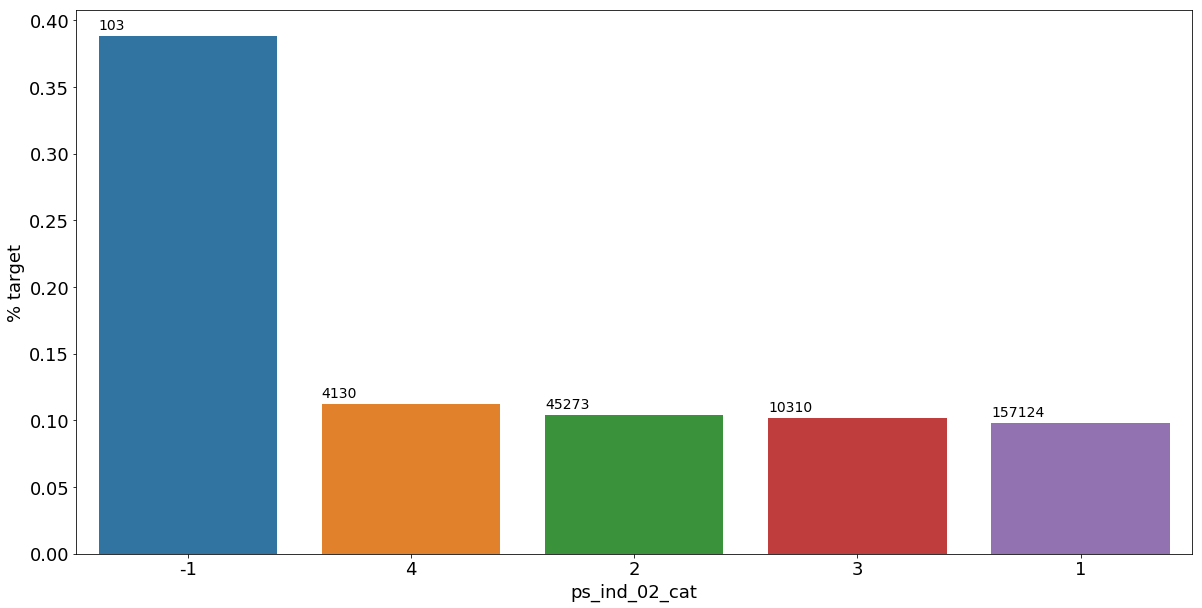

<Figure size 432x288 with 0 Axes>

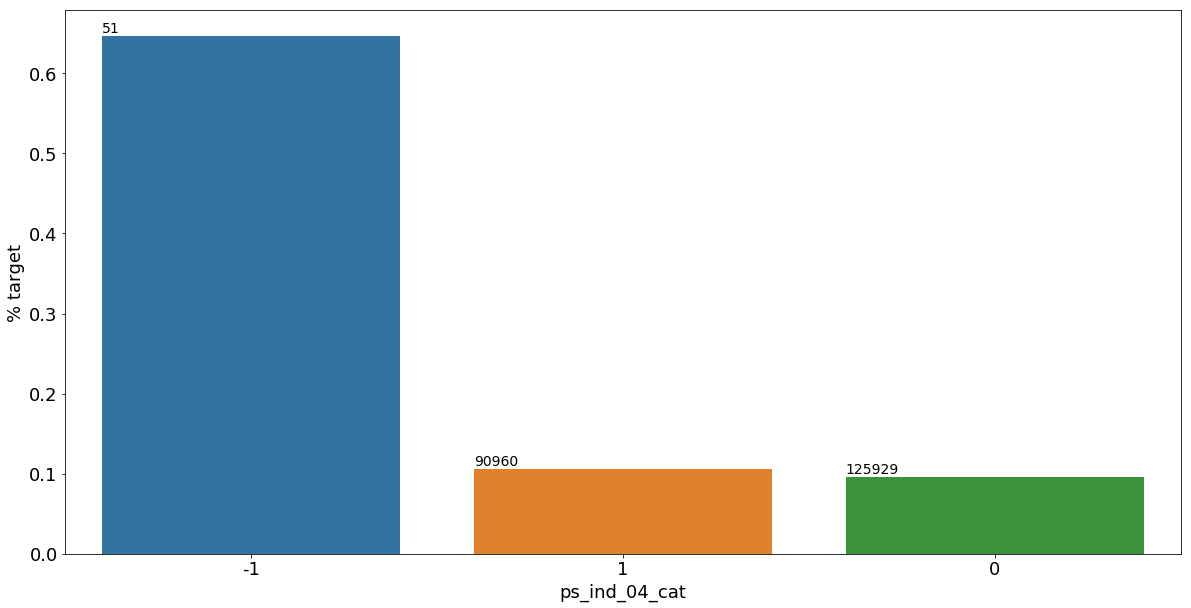

<Figure size 432x288 with 0 Axes>

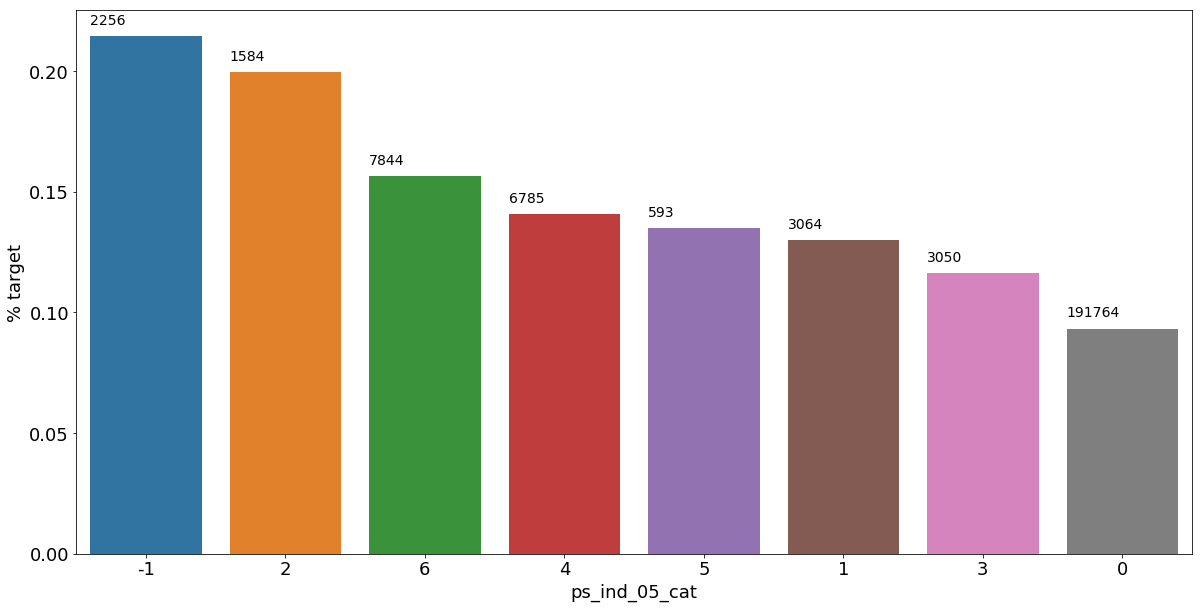

<Figure size 432x288 with 0 Axes>

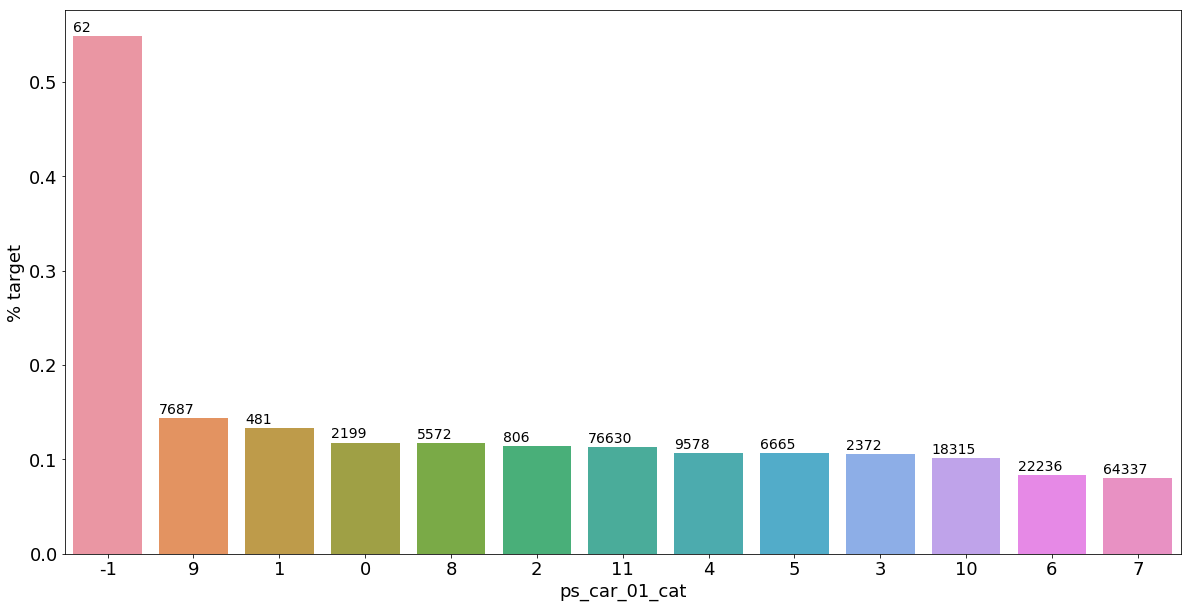

<Figure size 432x288 with 0 Axes>

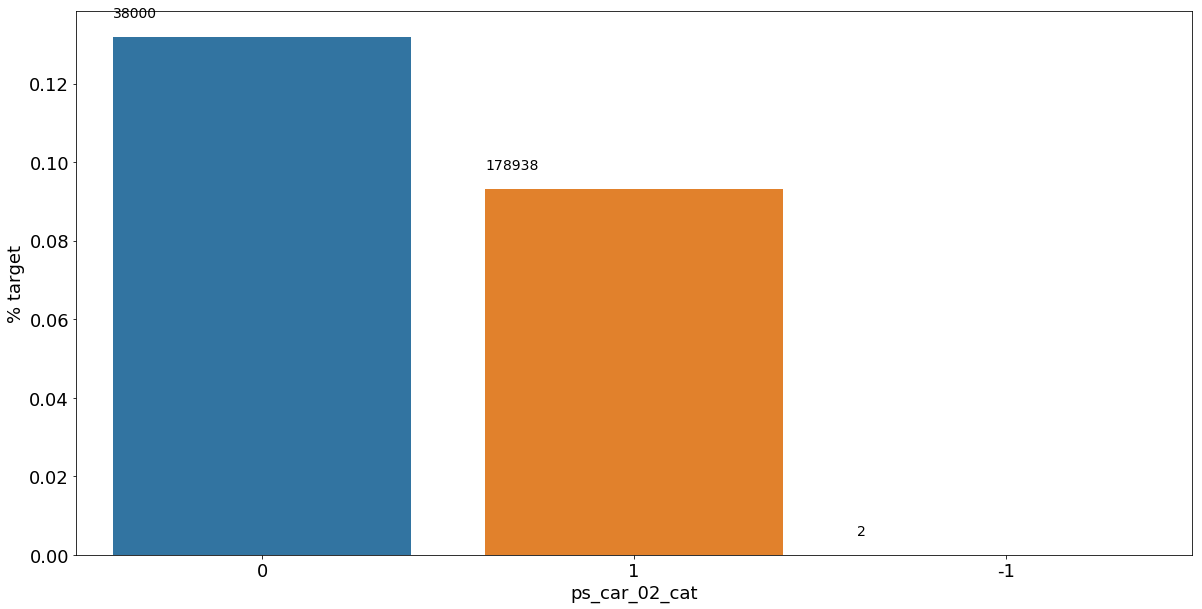

<Figure size 432x288 with 0 Axes>

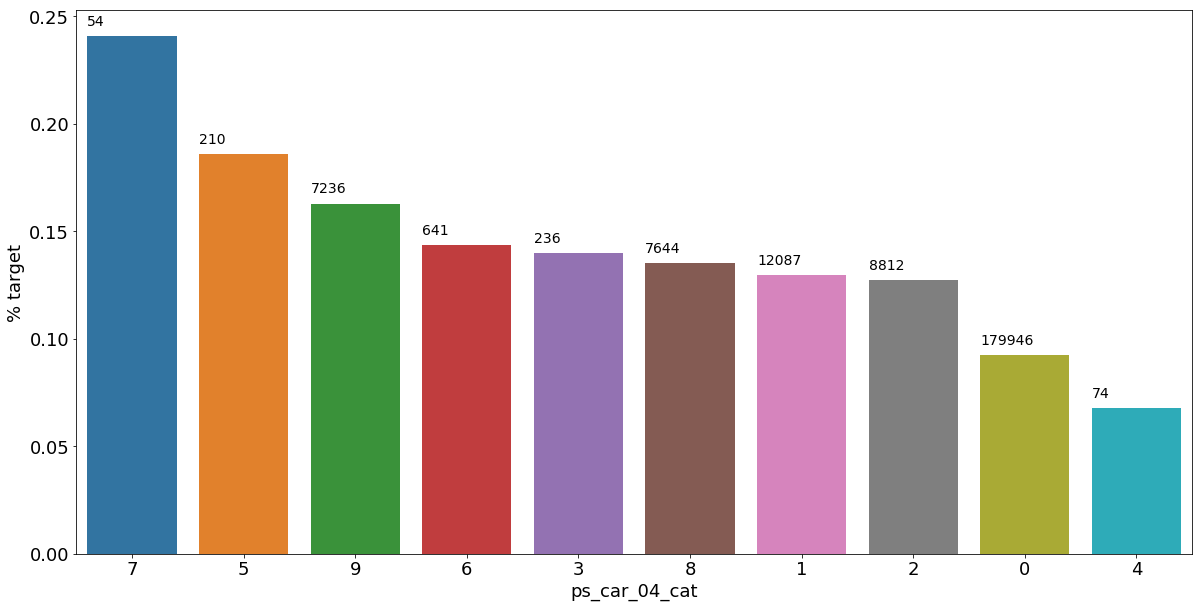

<Figure size 432x288 with 0 Axes>

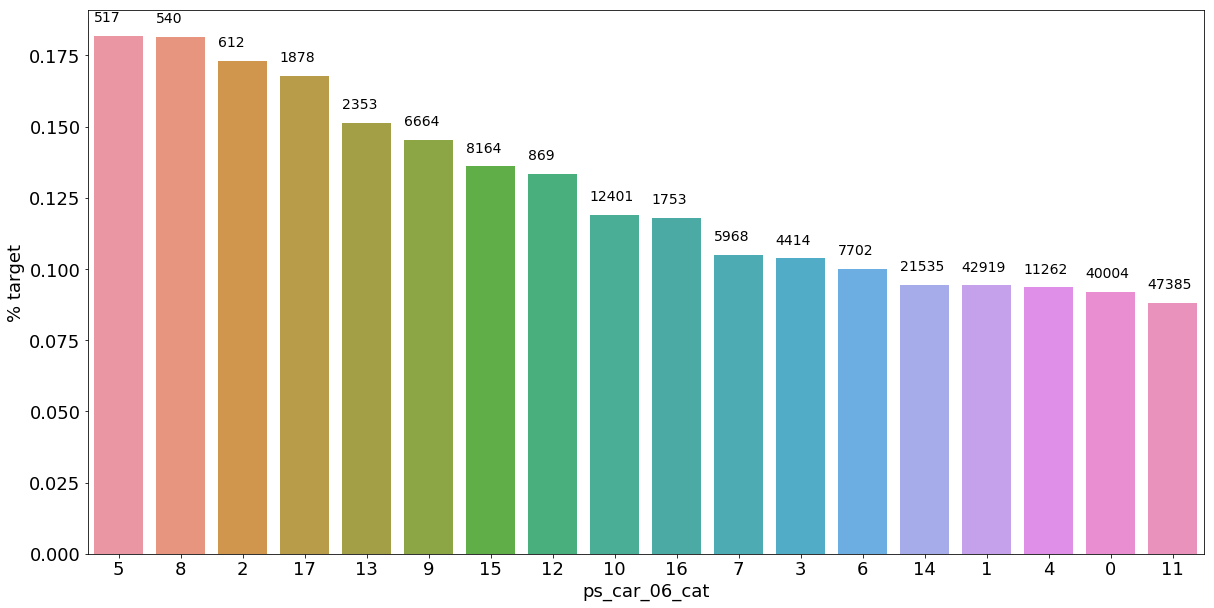

<Figure size 432x288 with 0 Axes>

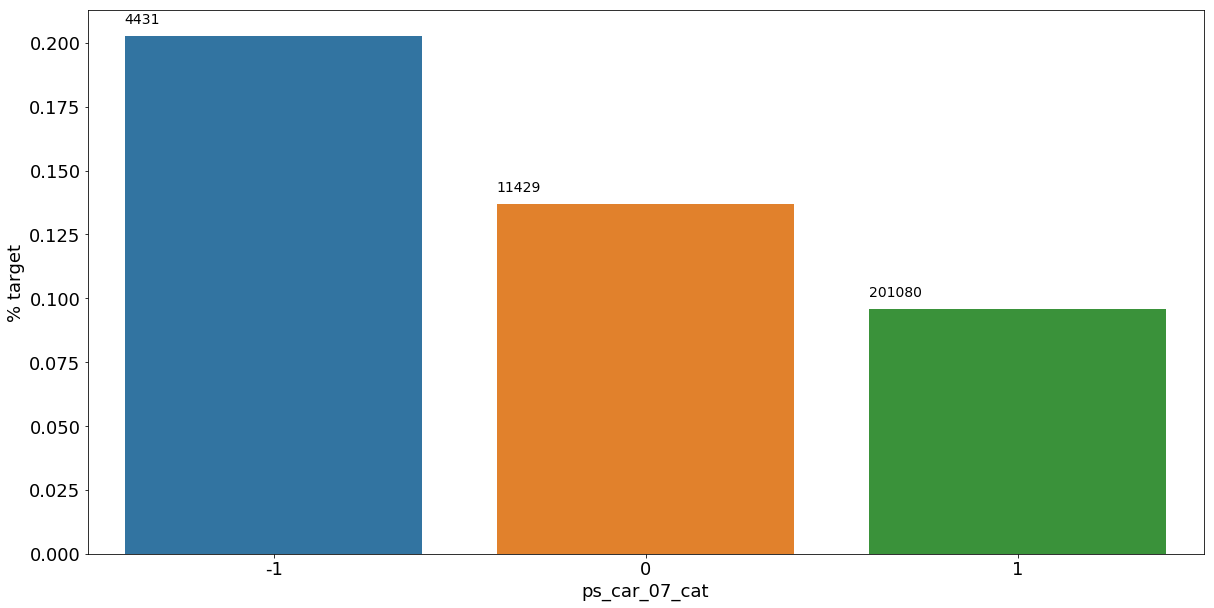

<Figure size 432x288 with 0 Axes>

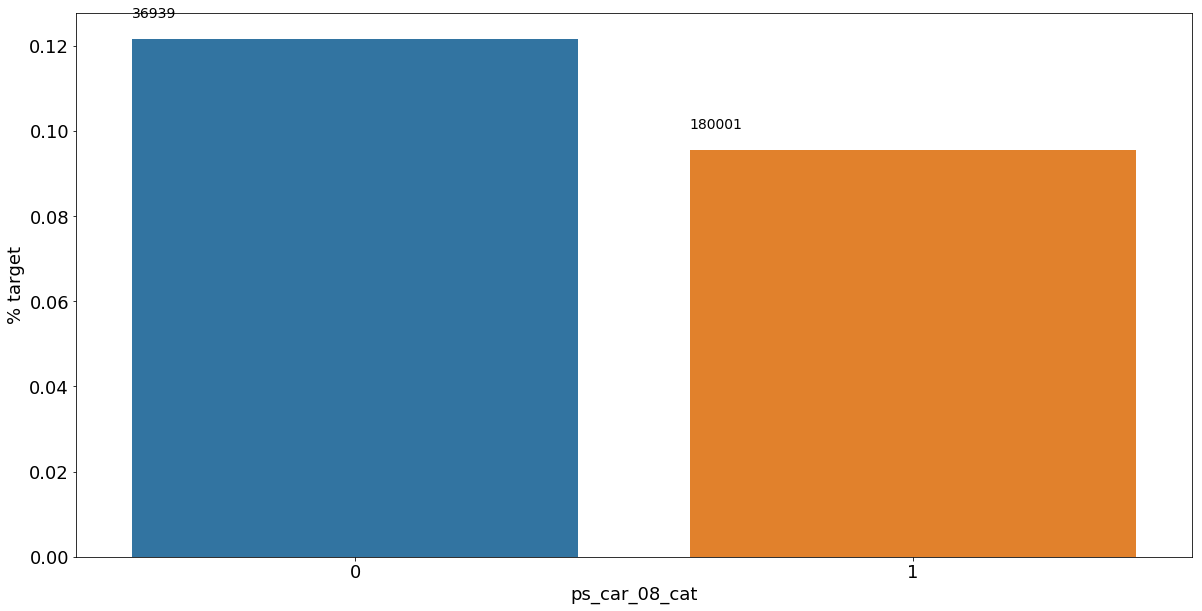

<Figure size 432x288 with 0 Axes>

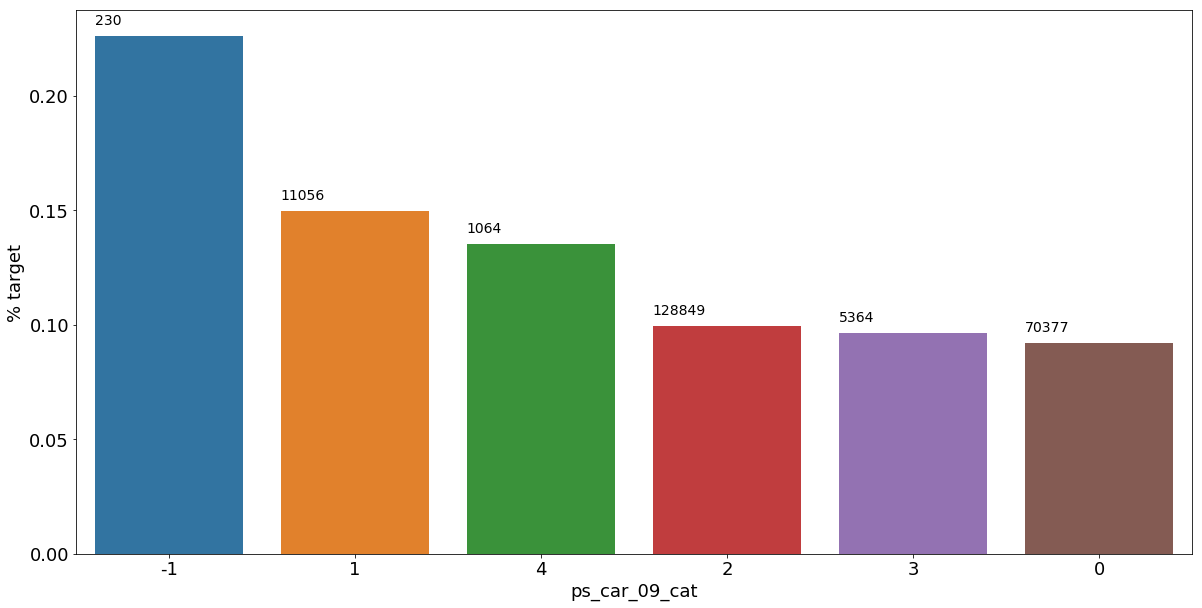

<Figure size 432x288 with 0 Axes>

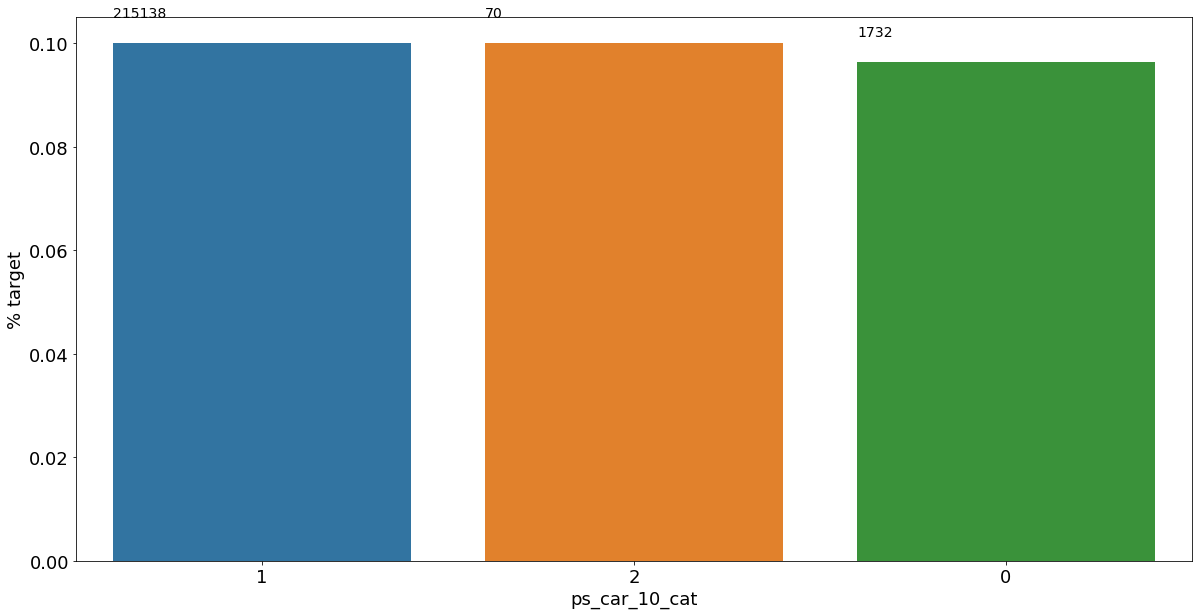

In [37]:
v = meta[(meta.level == "nominal") & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20, 10))
    # Calculate the percentage of target = 1 per category value
    cat_perc = train[[f, "target"]].groupby([f], as_index=False).agg(["mean", "count"])
    cat_perc = cat_perc.reset_index()
    cat_perc.sort_values(by=("target", "mean"), ascending=False, inplace=True)
    # Bar plot
    sns.barplot(ax=ax, x=f, y=("target", "mean"), data=cat_perc, order=cat_perc[f])
    for i, p in enumerate(ax.patches):
        ax.annotate('{}'.format(cat_perc['target']["count"].values[i]), (p.get_x(), p.get_height() + 0.005), fontsize=14)
    plt.ylabel("% target", fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis="both", which="major", labelsize=18)
    plt.show()

As we can see from the variables with missing values, it is a good idea to keep the missing valeus as a separate category value, instead of replacing them by the mode for instance. The customers with a missing value appear to have a much higher(insome cases much lower) probability to ask for an insurance claim

자칫 위험할 수도 있다. count를 따져봐야 하는데, 어떤 항목은 전부 0이지만, count개수가 2개밖에 안되기 때문에 신뢰할 수 없다. 유한님 malware kernel 보면 각 bar마다 count값을 따로 붙여놨다

## Interval variables
Checking the correlations between interval variables. A heatmap is a good way to visualize the correlation between variables. The code below is based on an example by Michael Waskom

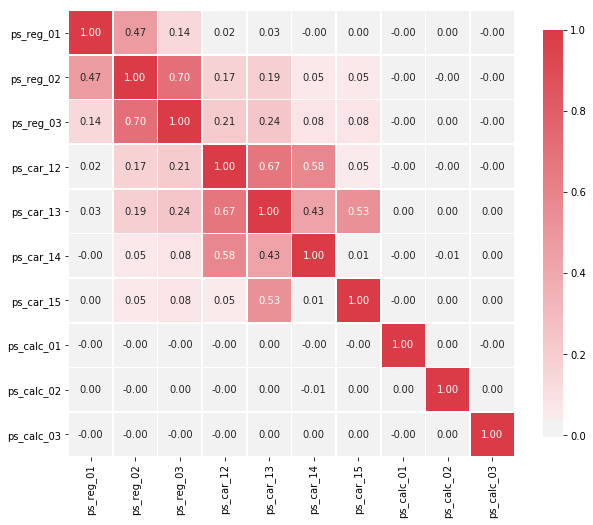

In [38]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

There are a strong correlations between the variables:
* ps_reg_02 and ps_reg_03 (0.7)
* ps_car_12 and ps_car13 (0.67)
* ps_car_12 and ps_car14 (0.58)
* ps_car_13 and ps_car15 (0.67)

Seaborn has some handy plots to visualize the (linear) relationship between variables. We could use a pairplot to visualize the relationship between the variables. But because the heatmap already showed the limited number of correlated variables, we'll look at each of the highly correlated variables separately.

**NOTE** : I take a sample of the train data to speed up the process.

In [39]:
s = train.sample(frac=0.1)

**ps_reg_02 and ps_reg_03**

As the regression line shows, there is a linear relationship between these variables. Thanks to the hue parameter we can see that the regression lines for target=0 and target=1 are the same.

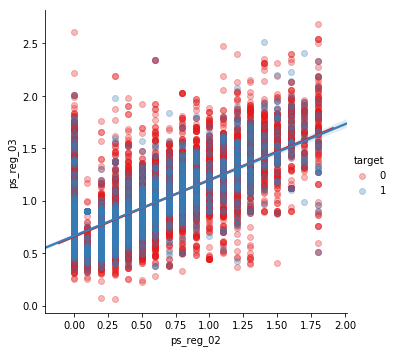

In [40]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

**ps_car_12 and ps_car_13**

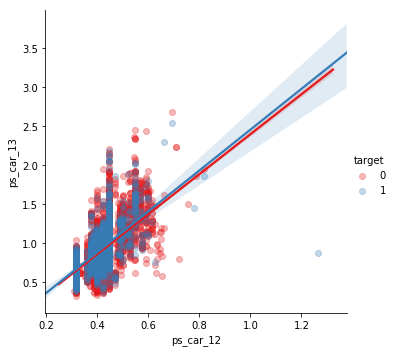

In [41]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

**ps_car_12 and ps_car_14**

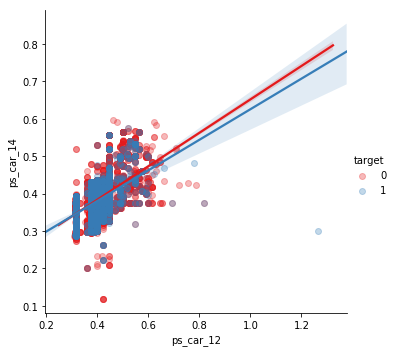

In [42]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

**ps_car_13 and ps_car_15**

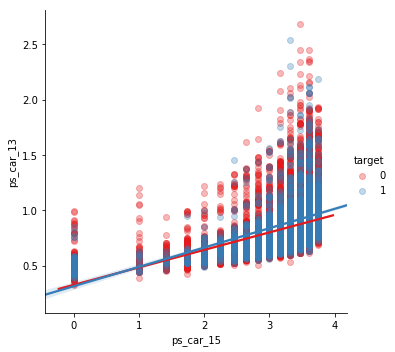

In [43]:
sns.lmplot(x="ps_car_15", y="ps_car_13", data=s, hue="target", palette="Set1", scatter_kws={"alpha" : 0.3})
plt.show()

Alright, so now what? How can we decide which of the correlated variables to keep? We could perform Principal COmponent Analuysis(PCA) onthe vairables to reduce the dimensions. In the AllState claims Severity Competition I made this kernel to do that. But as the number of correlated variables is rather low, we will let the model do the heavy-lifting.

## Checking the correlations between ordinal variables

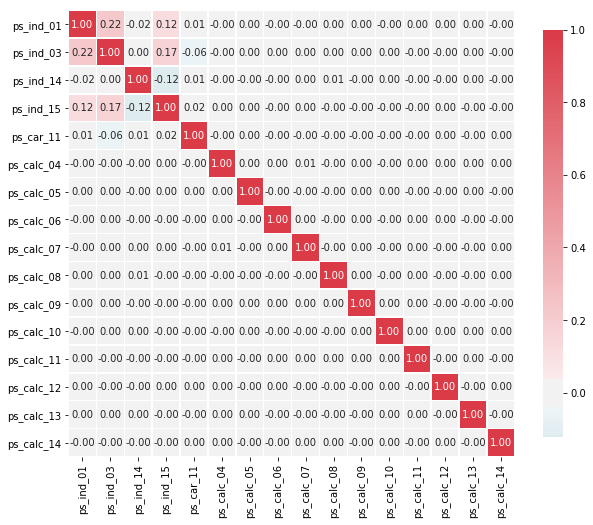

In [44]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

For the ordinal vairables we do not see mant correlations. We could, on the other hand, look at how the distributions are when grouping by the target value.

# Feature Engineering

## Creating dummy variables
feature 사이에 서로 곱하기

The values of the caregorical variables do not represent any order or magnitude. For nstance, caregory 2 is not twice the value of category 1. Therefore we can create dummy variables to deal with that. We drop the first dummy variables as this information can be derived from the other dummy variables generated for the vategories of the original variable.(카테고리 3개 있으면 두개만으로 원핫인코딩 해서 나타낼 수 있다는 의미)

In [45]:
v = meta[(meta.level == "nominal") & (meta.keep)].index
print("Before dummificatioan we have {} variabels in train".format(train.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
print("After dummification we have {} variables in train".format(train.shape[1]))

Before dummificatioan we have 57 variabels in train
After dummification we have 109 variables in train


So, creating dummy variables adds 52 variables to the training set.

## Creating interaction variables

In [46]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
# sklearn의 polynomialFeatures 함수 사용
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# interaction 적용한 데이터를 데이터 프레임으로 변환 후 interactions라고 저장
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))

interactions.drop(v, axis=1, inplace=True)  # Remove the original columns
# Concat the interaction variables to the train data
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
# concat 할 때 axis=0으로 하면 아래로 붙고(샘플을 붙일 경우), 1로 하면 옆으로 붙는다(feature를 붙일 경우)
train = pd.concat([train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 109 variables in train
After creating interactions we have 164 variables in train


In [47]:
interactions.head()

,ps_reg_01^2,ps_reg_01 ps_reg_02,ps_reg_01 ps_reg_03,ps_reg_01 ps_car_12,ps_reg_01 ps_car_13,ps_reg_01 ps_car_14,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02^2,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03^2,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12^2,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13^2,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14^2,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2
0,0.36,0.36,0.502892,0.221269,0.324362,0.207413,1.200000,0.54,0.18,0.00,0.36,0.502892,0.221269,0.324362,0.207413,1.200000,0.54,0.18,0.00,0.702500,0.309095,0.453108,0.289739,1.676305,0.754337,0.251446,0.000000,0.136,0.199365,0.127483,0.737564,0.331904,0.110635,0.000000,0.292252,0.186880,1.081207,0.486543,0.162181,0.000000,0.1195,0.691375,0.311119,0.103706,0.000000,4.0,1.800000,0.600000,0.000000,0.81,0.27,0.00,0.09,0.00,0.00
1,0.81,0.54,0.655596,0.381838,0.344658,0.340933,0.000000,0.18,0.00,0.54,0.36,0.437064,0.254558,0.229772,0.227288,0.000000,0.12,0.00,0.36,0.530625,0.309051,0.278958,0.275943,0.000000,0.145688,0.000000,0.437064,0.180,0.162473,0.160717,0.000000,0.084853,0.000000,0.254558,0.146653,0.145068,0.000000,0.076591,0.000000,0.229772,0.1435,0.000000,0.075763,0.000000,0.227288,0.0,0.000000,0.000000,0.000000,0.04,0.00,0.12,0.00,0.00,0.36
2,0.81,0.54,0.782340,0.360000,0.732844,0.362131,2.984962,0.27,0.81,0.09,0.36,0.521560,0.240000,0.488563,0.241421,1.989975,0.18,0.54,0.06,0.755625,0.347707,0.707819,0.349765,2.883032,0.260780,0.782340,0.086927,0.160,0.325708,0.160947,1.326650,0.120000,0.360000,0.040000,0.663037,0.327637,2.700631,0.244281,0.732844,0.081427,0.1619,1.334504,0.120710,0.362131,0.040237,11.0,0.994987,2.984962,0.331662,0.09,0.27,0.03,0.81,0.09,0.01
3,0.36,0.90,1.023523,0.240000,0.503032,0.227051,2.163331,0.48,0.24,0.06,2.25,2.558808,0.600000,1.257580,0.567627,5.408327,1.20,0.60,0.15,2.910000,0.682349,1.430181,0.645532,6.150610,1.364698,0.682349,0.170587,0.160,0.335355,0.151367,1.442221,0.320000,0.160000,0.040000,0.702893,0.317260,3.022847,0.670710,0.335355,0.083839,0.1432,1.364405,0.302734,0.151367,0.037842,13.0,2.884441,1.442221,0.360555,0.64,0.32,0.08,0.16,0.04,0.01
4,0.64,0.64,0.869253,0.320000,0.724622,0.307870,2.884441,0.48,0.40,0.72,0.64,0.869253,0.320000,0.724622,0.307870,2.884441,0.48,0.40,0.72,1.180625,0.434626,0.984186,0.418151,3.917668,0.651939,0.543283,0.977909,0.160,0.362311,0.153935,1.442221,0.240000,0.200000,0.360000,0.820432,0.348577,3.265825,0.543466,0.452888,0.815199,0.1481,1.387552,0.230903,0.192419,0.346354,13.0,2.163331,1.802776,3.244996,0.36,0.30,0.54,0.25,0.45,0.81


# Feature selection

## Removing features with low or zero variance

Personally, I prefer to let the classifier algorithm chose which features to keep. But there is one thing that we can do ourselves. That is removing features with no or a very low variance. Sklearn has a handy method to do that: VarianceThreshold. By default it removes features with zero variance. This will not be applicable for this competition as we saw there are no zero-variance variables in the previous steps. But if we would remove features with less than 1% variance, we would remove 31 variables.

In [48]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

# selector.get_support()한 결과의 반대가 필요하기 때문에 np.vectorize(lambda x : not x)를 사용한다
f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

28 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


We would lose rather many variables if we would select based on variance. But because we do not have so many variables, we'll let the classifier chose. For data sets with many more variables this could reduce the processing time.

Sklearn also comes with other feature selection methods. One of these methods is SelectFromModel in which you let another classifier select the best features and continue with these. Below I'll show you how to do that with a Random Forest.

28개 지우는 것은 너무 많이 지우니까 randomForest이용해서 feature 선택하자

## Selecting features with a Random Forest and SelectFromModel
Here we'll base feature selection on the feature importances of a random forest. With Sklearn's SelectFromModel you can then specify how many variables you want to keep. You can set a threshold on the level of feature importance manually. But we'll simply select the top 50% best variables

In [49]:
%%time
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_11_cat_te               0.021073
 2) ps_car_13                      0.017355
 3) ps_car_12 ps_car_13            0.017291
 4) ps_car_13^2                    0.017231
 5) ps_car_13 ps_car_14            0.017130
 6) ps_reg_03 ps_car_13            0.017045
 7) ps_car_13 ps_car_15            0.016788
 8) ps_reg_01 ps_car_13            0.016727
 9) ps_reg_03 ps_car_14            0.016234
10) ps_reg_03 ps_car_12            0.015526
11) ps_reg_03 ps_car_15            0.015205
12) ps_car_14 ps_car_15            0.015064
13) ps_car_13 ps_calc_01           0.014775
14) ps_car_13 ps_calc_03           0.014703
15) ps_reg_01 ps_reg_03            0.014693
16) ps_car_13 ps_calc_02           0.014682
17) ps_reg_02 ps_car_13            0.014638
18) ps_reg_01 ps_car_14            0.014404
19) ps_reg_03^2                    0.014292
20) ps_reg_03                      0.014287
21) ps_reg_03 ps_calc_01           0.013781
22) ps_reg_03 ps_calc_03           0.013769
23) ps_reg_03 ps_calc_02        

With SelectFromModel we can specify which prefit classifier to use and what the threshold is for the feature importances. With the get_support method we can then limit the number of variables in the train data.

In [50]:
# median 이하면 없앤다
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 162
Number of features after selection: 81


In [51]:
train = train[selected_vars + ['target']]

# Feature scaling
As mentioned before, we can apply standard scaling to the training data. Some classifiers perform better when this is done.

In [52]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))
# 주의 할 점은 train dataSet으로 fit_transform한 뒤에 test dataSet은 transform만 한다는 것

array([[-0.45941104, -1.26665356,  1.05087653, ..., -0.72553616,
        -1.01071913, -1.06173767],
       [ 1.55538958,  0.95034274, -0.63847299, ..., -1.06120876,
        -1.01071913,  0.27907892],
       [ 1.05168943, -0.52765479, -0.92003125, ...,  1.95984463,
        -0.56215309, -1.02449277],
       ...,
       [-0.9631112 ,  0.58084336,  0.48776003, ..., -0.46445747,
         0.18545696,  0.27907892],
       [-0.9631112 , -0.89715418, -1.48314775, ..., -0.91202093,
        -0.41263108,  0.27907892],
       [-0.45941104, -1.26665356,  1.61399304, ...,  0.28148164,
        -0.11358706, -0.72653353]])

# Conclusion
Hopefully this notebook helped you with some tips on how to start with this competition. Feel free to vote for it. And if you have questions, post a comment.

In [53]:
print(train.shape)
print(test.shape)

(216940, 82)
(892816, 58)
